# Checking encoder embeddings

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import sklearn as sk
import scipy as sc
import seaborn as sns
import seaborn_image as isns

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

In [5]:
#import itables
#from itables import show

In [6]:
from collections import namedtuple
import itertools
from itertools import product

In [7]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [8]:
import PIL as pil
from PIL import Image, ImageDraw

In [9]:
import geopy as gp

In [10]:
#import papermill as pm

In [11]:
import math

In [12]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [13]:
import os

In [14]:
import functools

## Load our model

In [15]:
import torch
from einops import rearrange, reduce, repeat

In [16]:
torch.cuda.is_available()

True

In [17]:
device = torch.device('cuda')

In [18]:
from Prithvi import MaskedAutoencoderViT

In [19]:
model = MaskedAutoencoderViT(
    img_size=224,
    patch_size=16,
    num_frames=1,
    tubelet_size=1,
    in_chans=6,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    mlp_ratio=4.,
    norm_layer=functools.partial(torch.nn.LayerNorm, eps=1e-6),
    norm_pix_loss=False
)

In [20]:
weights = torch.load("Prithvi_100M.pt")

In [21]:
weights['pos_embed'] = weights['pos_embed'][:,:197,:768]
weights['decoder_pos_embed'] = weights['decoder_pos_embed'][:,:197,:512]

In [22]:
model.load_state_dict(weights)

<All keys matched successfully>

In [23]:
model = model.to(device)

## Load our data back in

In [24]:
os.chdir('E:/27-8-2023')

In [25]:
img_18Dec2020 = np.load('E:/syncable2/img_18Dec2020.npy')

In [26]:
img_10May2021 = np.load('E:/syncable2/img_10May2021.npy')

In [27]:
df = pd.read_pickle('df_intermediate.pickle')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   67 non-null     int64 
 1   name    67 non-null     object
 2   y0      67 non-null     int64 
 3   y1      67 non-null     int64 
 4   x0      67 non-null     int64 
 5   x1      67 non-null     int64 
 6   src     67 non-null     object
 7   crop    67 non-null     object
dtypes: int64(5), object(3)
memory usage: 4.3+ KB


### What's the size of our input image here?

In [29]:
img_18Dec2020.shape

(7620, 4876, 9)

### Can we do a sliding-window with overlaps?

In [30]:
img_18Dec2020_torch = torch.Tensor(img_18Dec2020)

In [31]:
img_18Dec2020_torch = img_18Dec2020_torch.unfold(0, 224, 16).unfold(1, 224, 16)

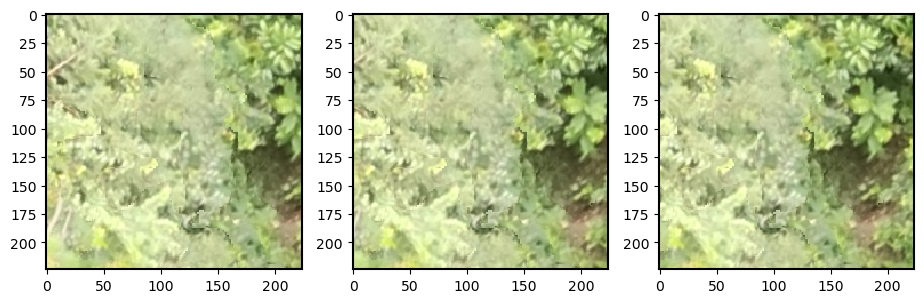

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(5.6*2, 4.8))
[ax.imshow(rearrange(img_18Dec2020_torch[100,100+i,:3].numpy(), 'c h w -> h w c').astype('uint8'),
           vmin=0, vmax=255)
 for i, ax in zip(range(3), ax.flatten())]

### Now run the encoder and plot it below

In [33]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [34]:
channels = [bands.index(i) for i in ['wr', 'wg', 'wb', *(('nir',)*3)]]

In [35]:
crops = [rearrange(img_18Dec2020_torch[100,100+i,channels], '(b c t) h w -> b c t h w', b=1, t=1)
         for i, ax in zip(range(3), ax.flatten())]

In [36]:
crops_encoded = [model.forward_encoder(i.to(device), mask_ratio=0) for i in tqdm(crops)]

  0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
crops_encoded = [rearrange(i[0][:,1:].squeeze().detach().cpu().numpy(),
                           '(h w) c -> h w c', h=14, w=14)
                 for i in crops_encoded]

<Axes: ylabel='Count'>

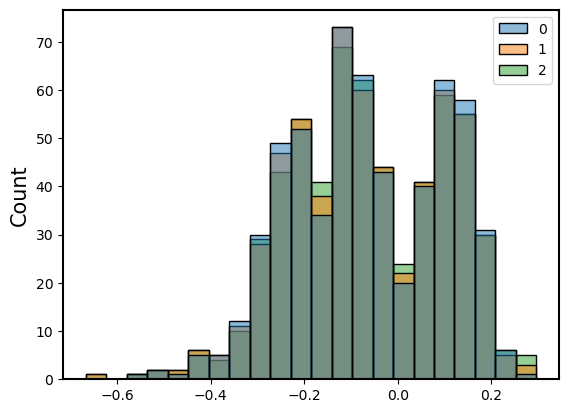

In [38]:
sns.histplot([i[:,:,:3].flatten() for i in crops_encoded])

<Axes: ylabel='Count'>

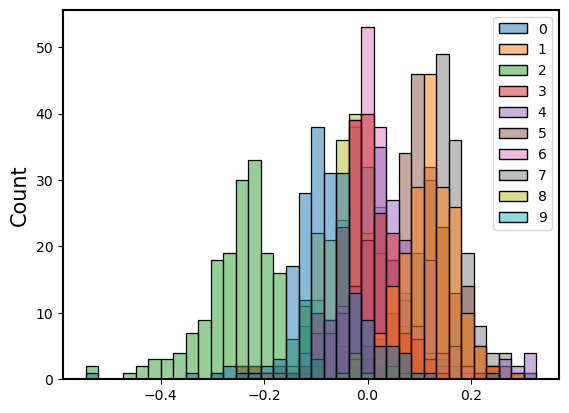

In [39]:
sns.histplot([crops_encoded[0][:,:,i].flatten() for i in range(10)])#crops_encoded[0].shape[-1])])

In [40]:
crops = [rearrange(img_18Dec2020_torch[100,100+i,channels], '(b c t) h w -> b c t h w', b=1, t=1)
         for i in [0, 1, 2, 100]]

In [47]:
crops_encoded = [model.forward_encoder(i.to(device), mask_ratio=0) for i in tqdm(crops)]
crops_encoded = [rearrange(i[0][:,1:].squeeze().detach().cpu().numpy(),
                           '(h w) c -> h w c', h=14, w=14)
                 for i in crops_encoded]

  0%|          | 0/4 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


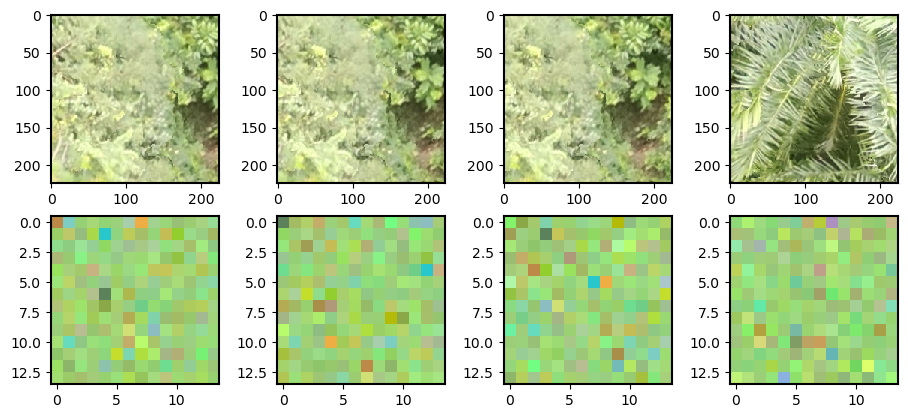

In [42]:
fig, ax = plt.subplots(2, 4, figsize=(5.6*2, 4.8))
[ax.imshow(rearrange(i.numpy(), 'b c t h w -> b t h w c').squeeze().astype('uint8')[:,:,:3],
           vmin=0, vmax=1)
 for i, ax in zip(crops, ax[0])]
[ax.imshow(i[:,:,:3] + 0.7,
           vmin=0, vmax=1)
 for i, ax in zip(crops_encoded, ax[1])]

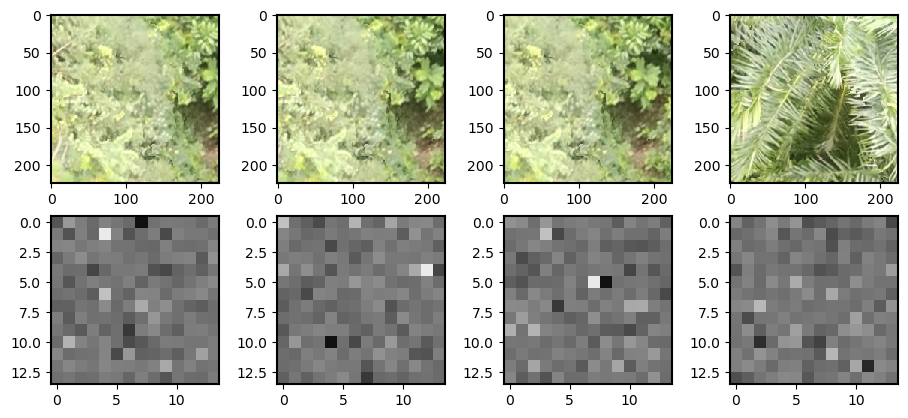

In [43]:
fig, ax = plt.subplots(2, 4, figsize=(5.6*2, 4.8))
[ax.imshow(rearrange(i.numpy(), 'b c t h w -> b t h w c').squeeze().astype('uint8')[:,:,:3],
           vmin=0, vmax=1)
 for i, ax in zip(crops, ax[0])]
[ax.imshow(i[:,:,0] + 0.7,
           vmin=0, vmax=1, cmap='Greys')
 for i, ax in zip(crops_encoded, ax[1])]

### Can we look at the cross-correlations?

In [149]:
from scipy.signal import correlate, correlate2d

In [99]:
from skimage.feature import match_template

In [45]:
crops_ = [rearrange(i.numpy(), 'b c t h w -> b t h w c').squeeze()
          for i in crops]

In [166]:
def fix_central_bias(x):
    x = x.copy()
    m, n = x.shape[:2]
    cent_m, cent_n = m // 2, n // 2
    for i in range(m):
        for j in range(n):
            overlap_size = (m-abs(cent_m-i)) * (n-abs(cent_n-j))
            x[i,j] /= overlap_size
    return x

In [169]:
crops_correlations =\
[np.stack([match_template(crop1[:,:,i],
                          crop2[:,:,i],
                          pad_input=True)
           for i in range(3)],
          axis=-1)
 for crop1, crop2 in tqdm(itertools.islice(itertools.pairwise(itertools.cycle(crops_)), len(crops_)))]

0it [00:00, ?it/s]

In [170]:
crops_correlations[0].shape

(224, 224, 3)

<Axes: ylabel='Density'>

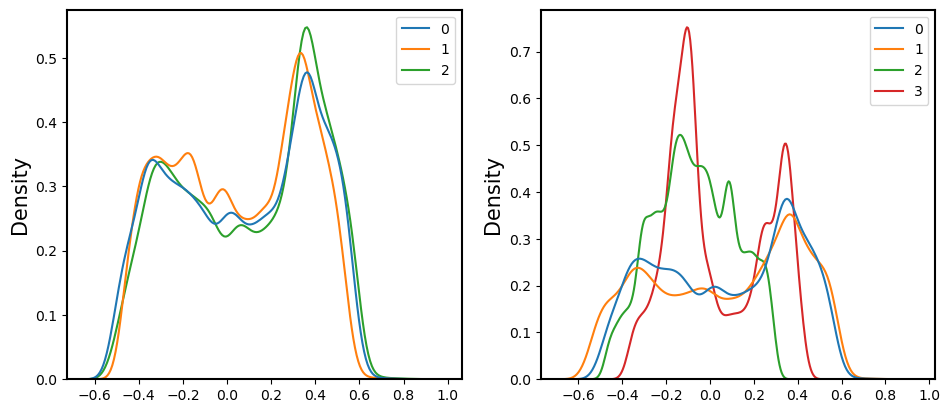

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.kdeplot([crops_correlations[0][:,:,i].flatten() for i in range(crops_correlations[0].shape[-1])],
             ax=ax[0])
sns.kdeplot([i.mean(axis=-1).flatten() for i in crops_correlations],
             ax=ax[1])

In [172]:
enc_correlations =\
[np.stack([match_template(crop1[:,:,i],
                          crop2[:,:,i],
                          pad_input=True)
           for i in range(crops_encoded[0].shape[-1])],
          axis=-1)
 for crop1, crop2 in tqdm(itertools.islice(itertools.pairwise(itertools.cycle(crops_encoded)), len(crops_)))]

0it [00:00, ?it/s]

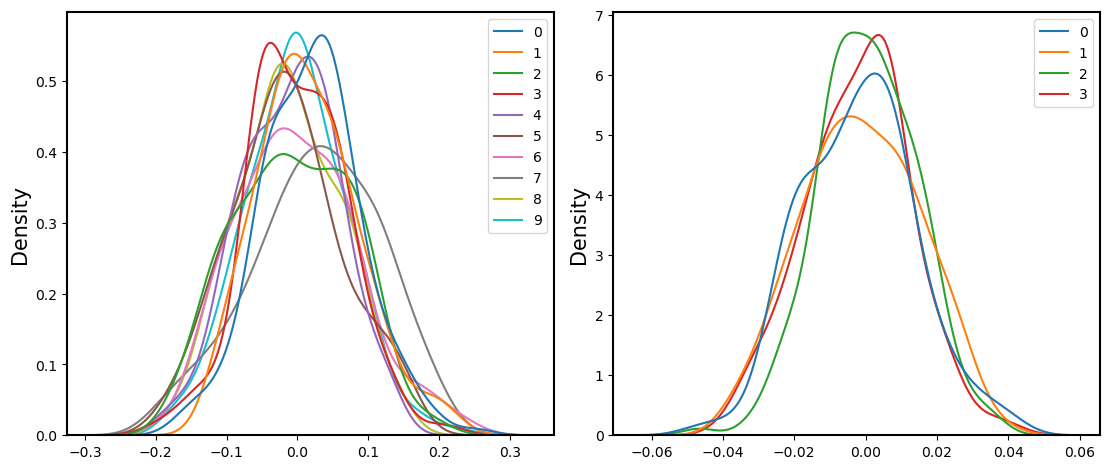

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
sns.kdeplot([enc_correlations[0][:,:,i].flatten() for i in range(10)],
             ax=ax[0])
sns.kdeplot([i.mean(axis=-1).flatten() for i in enc_correlations],
             ax=ax[1])
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[None, None, None]

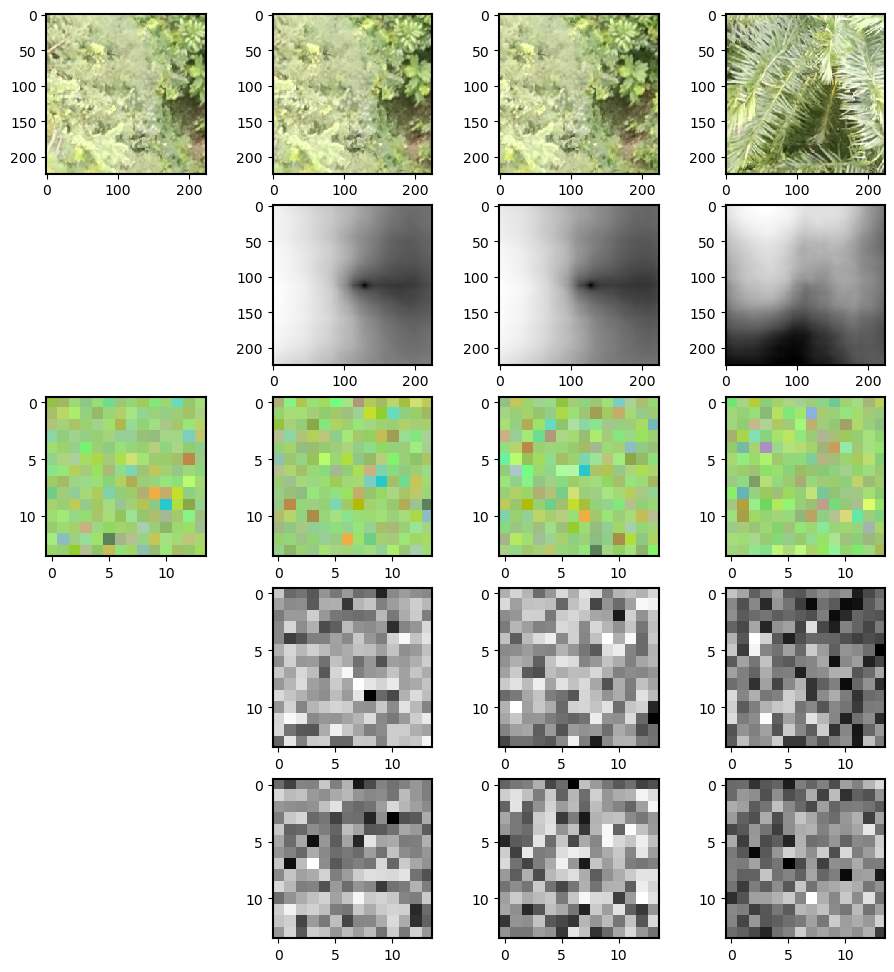

In [188]:
fig, ax = plt.subplots(5, 4, figsize=(5.6*2, 4.8*2.5))
[ax.imshow(i.astype('uint8')[:,:,:3],
           vmin=0, vmax=1)
 for i, ax in zip(crops_, ax[0])]
[ax.imshow(i.mean(axis=-1), cmap='Greys')#, vmin=-0.6, vmax=0.6)
 for i, ax in zip(crops_correlations, ax[1][1:])]
[ax.imshow(i[:,:,:3] + 0.7,
           vmin=0, vmax=1)#, cmap='Greys')
 for i, ax in zip(crops_encoded, ax[2])]
[ax.imshow(i[:,:,:1].mean(axis=-1), cmap='Greys')#, vmin=-0.3, vmax=0.3)
 for i, ax in zip(enc_correlations, ax[3][1:])]
[ax.imshow(i.mean(axis=-1), cmap='Greys')#, vmin=-0.06, vmax=0.06)
 for i, ax in zip(enc_correlations, ax[4][1:])]
[fig.delaxes(i) for i in ax[[1,3,4],0].flatten()]

## Can we perform various degrees of downscaling?

In [189]:
img_18Dec2020.shape, img_10May2021.shape

((7620, 4876, 9), (8088, 5392, 9))

In [193]:
4096 // 2**4

256

In [205]:
img_.shape

(7620, 4876, 9)

In [206]:
img.shape[0] % 2**i

0

In [214]:
from skimage.transform import downscale_local_mean
downscales = dict()
for i in range(1, 4+1):
    for img in tqdm([img_18Dec2020, img_10May2021]):
        downscales[i, 'img_18Dec2020' if img is img_18Dec2020 else 'img_10May2021'] =\
            downscale_local_mean(img, (2**i,2**i,1))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [216]:
list(downscales.keys())

[(1, 'img_18Dec2020'),
 (1, 'img_10May2021'),
 (2, 'img_18Dec2020'),
 (2, 'img_10May2021'),
 (3, 'img_18Dec2020'),
 (3, 'img_10May2021'),
 (4, 'img_18Dec2020'),
 (4, 'img_10May2021')]

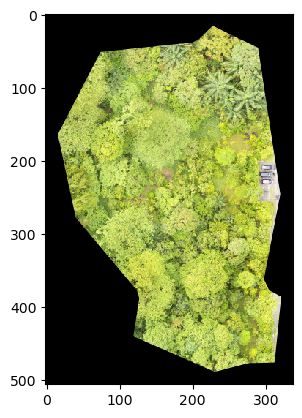

In [218]:
plt.imshow(downscales[(4, 'img_10May2021')][:,:,:3].astype('uint8'))

In [219]:
with open('downscales.pickle', 'wb') as f:
    pickle.dump(downscales, f)

In [225]:
with open('downscales.pickle', 'rb') as f:
    downscales = pickle.load(f)

In [252]:
import math

In [259]:
channels

[0, 1, 2, 6, 6, 6]

In [376]:
downscales_embeds = dict()
for key, img in downscales.items():
    img = img[:,:,channels]
    img = rearrange(img, '(b t h) w c -> b c t h w', b=1, t=1)
    
    original_h, original_w = img.shape[-2:]
    pad_h = 224 - (original_h % 224)
    pad_w = 224 - (original_w % 224)
    img = np.pad(img, ((0, 0), (0, 0), (0, 0), (0, pad_h), (0, pad_w)), mode='reflect')

    img = torch.Tensor(img)
    img_ = img
    img = img.unfold(3, 224, 224//2).unfold(4, 224, 224//2)

    post_fold_shape = img.shape
    img = rearrange(img, 'b c t h1 w1 h w -> (b h1 w1) c t h w', h=224, w=224)
    
    batch_size = 16
    num_batches = math.ceil(img.shape[0] / batch_size) if img.shape[0] > batch_size else 1
    img = torch.tensor_split(img, num_batches, dim=0)

    rec_imgs = []
    for x in tqdm(img):
        with torch.no_grad():
            rec_img, mask_img, _ = model.forward_encoder(x.to(device), 0)
            del mask_img, _
            rec_img = rec_img[:,1:]
            rec_imgs.append(rec_img.cpu())

    rec_imgs = torch.concat(rec_imgs, dim=0)

    post_pad_h = original_h + pad_h
    post_pad_w = original_w + pad_w

    rec_imgs = rearrange(rec_imgs,
                         '(b h1 w1) (h w) e -> b h1 w1 h w e',
                         b=1,
                         h1=post_fold_shape[3], w1=post_fold_shape[4],
                         h=14, w=14, e=768)

    rec_imgs = rearrange(rec_imgs,
                         'b h1 w1 h w e -> b (h1 h) (w1 w) e')
    rec_imgs = rec_imgs.unfold(1, 14, 14*2).unfold(2, 14, 14*2)
    rec_imgs = rearrange(rec_imgs,
                         'b h1 w1 e h w -> b (h1 h) (w1 w) e')
    
    downscales_embeds[key] = rec_imgs

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [377]:
with open('downscales_embeds.pickle', 'wb') as f:
    pickle.dump(downscales_embeds, f)